<a href="https://colab.research.google.com/github/4cea2/7506R-2C2023-GRUPO26/blob/main/7506R_TP1_GRUPO26_CHP2_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo practico 1 - Checkpoint 2**
**Grupo**: 26

**Integrantes**:

Garcia, Nicolas

Vallcorba, Agustin

Carbajal Robles, Kevin Emir

## **Librerias y carga del data set**

In [ ]:
!pip install 'dtreeviz'

In [ ]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Cargamos el dataset de entrenamiento, que es el que obtuvimos en el checkpoint 1.

De igual manera lo haremos para el dataset de test y el de train original.

In [ ]:
#Dataset de entrenamiento
ds_train = pd.read_csv('sample_data/dataset_final.csv')

#Dataset de test
ds_test = pd.read_csv("https://drive.google.com/u/1/uc?id=1ruDne6JVJTwK0TbDNQEUfUtoxA6gVTiy&export=download")

#Copia
ds_test_copia = ds_test.copy()

#Dataset de entrenamiento original
df = pd.read_csv("https://drive.google.com/u/0/uc?id=1tjlunFxE63XIpYjWk8SPm2XPxixu8SW4&export=download")

## **Limpieza de los dataset**

Para entrenar los modelos, tenemos que verificar que ambos dataset (train y test) cuenten con las mismas columnas.

Por ende, haremos las mismas transformaciones que hicimos en el train al test.

In [ ]:
ds_train.dtypes

hotel                           object
lead_time                        int64
arrival_date_year                int64
arrival_date_month              object
arrival_date_day_of_month        int64
adults                           int64
children                         int64
babies                           int64
meal                            object
country                         object
market_segment                  object
distribution_channel            object
is_repeated_guest                int64
reserved_room_type              object
assigned_room_type              object
booking_changes                  int64
deposit_type                    object
agent                          float64
company                        float64
days_in_waiting_list             int64
customer_type                   object
adr                            float64
required_car_parking_spaces      int64
total_of_special_requests        int64
id                              object
is_canceled              

In [ ]:
ds_test_copia.dtypes

hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

Observamos el porcentaje de sus valores nulos en funcion de la columna misma.

In [ ]:
filas_totales=ds_test_copia.shape[0]
print(ds_test_copia.isna().sum()/filas_totales*100)
print(ds_test_copia.shape)

hotel                              0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.000000
babies                             0.000000
meal                               0.000000
country                            0.358018
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                       0.000000
agent                           

Apliquemos las transformaciones y eliminaciones de columnas.

In [ ]:
#En el DataFrame que comenzamos a filtrar, unimos el valor de las dos columnas en uno solo
ds_test_copia["nights_of_stay"] = ds_test_copia['stays_in_week_nights'] + ds_test_copia['stays_in_weekend_nights']
ds_test_copia["reservations"] = ds_test_copia['previous_cancellations'] + ds_test_copia['previous_bookings_not_canceled']

#Eliminamos ambas columnas de nuestro DataFrame
ds_test_copia = ds_test_copia.drop('stays_in_week_nights', axis=1)
ds_test_copia = ds_test_copia.drop('stays_in_weekend_nights', axis=1)
ds_test_copia = ds_test_copia.drop('previous_cancellations', axis=1)
ds_test_copia = ds_test_copia.drop('previous_bookings_not_canceled', axis=1)

#Eliminamos columnas innecesarias
ds_test_copia = ds_test_copia.drop('arrival_date_week_number', axis=1)
ds_test_copia = ds_test_copia.drop('id', axis=1)
ds_test_copia = ds_test_copia.drop('reservation_status_date', axis=1)

In [ ]:
#Reemplazamos valores NaNs por 0
columnas_a_reemplazar = ['company', 'agent']
ds_test_copia[columnas_a_reemplazar] = ds_test_copia[columnas_a_reemplazar].fillna(0)

In [ ]:
#Mediana de children
mediana = ds_test_copia['children'].median()

# Convertir la columna "children" de float a enteros y reemplazar NaN con la mediana
ds_test_copia["children"] = pd.to_numeric(ds_test_copia["children"], downcast="integer", errors="coerce").fillna(mediana).astype(int)

En el train, decidimos eliminar los registros donde la variable **country** tomaba valores nulos, pero en el test no podemos hacer esto.

Reemplazaremos los valores nulos por la moda, asi podemos trabajar con estos registros.

In [ ]:
#Moda de country
moda = ds_test_copia['country'].mode()[0]

#Reemplazar los NaN por la moda
ds_test_copia['country'].fillna(moda, inplace=True)

Ahora, tenemos que tener cuidado con las columnas de tipo object, ya que al entrenar los modelos, necesitamos que las columnas sean si o si numericas.

In [ ]:
#Columnas object del train
columnas_train_object = ds_train.select_dtypes(include=['object'])

columnas_train_object.columns.tolist()

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'id']

In [ ]:
#Columnas object del test
columnas_test_object = ds_test_copia.select_dtypes(include=['object'])

columnas_test_object.columns.tolist()

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

Eliminaremos tambien la columna id del dataset de train, ya que no sera necesaria cuando entrenemos los modelos.

In [ ]:
ds_train = ds_train.drop('id', axis=1)

### **Conversiones**

Una vez identificadas estas columnas categoricas, tenemos que aplicar una conversion de variables categoricas.

Para esto, usaremos las conversiones principales **One Hot Encoding (dummies)** y **Ordinal Encoder**.

Dependiendo si los valores que puedan tomar estas columnas son las mismas que tomaron en el train, aplicaremos una o otra conversion.

In [ ]:
#hotel
ds_test_copia['hotel'].value_counts()

City Hotel      18295
Resort Hotel     8240
Name: hotel, dtype: int64

In [ ]:
#arrival_date_month
ds_test_copia['arrival_date_month'].value_counts()

August       3115
July         2780
May          2656
April        2591
June         2526
October      2487
September    2347
March        2109
February     1698
November     1481
December     1467
January      1278
Name: arrival_date_month, dtype: int64

In [ ]:
#meal
ds_test_copia['meal'].value_counts()

BB           20629
HB            3094
SC            2369
Undefined      238
FB             205
Name: meal, dtype: int64

In [ ]:
#deposit_type
ds_test_copia['deposit_type'].value_counts()

No Deposit    22112
Non Refund     4396
Refundable       27
Name: deposit_type, dtype: int64

In [ ]:
#customer_type
ds_test_copia['customer_type'].value_counts()

Transient          20310
Transient-Party     5248
Contract             886
Group                 91
Name: customer_type, dtype: int64

In [ ]:
#reserved_room_type
ds_test_copia['reserved_room_type'].value_counts()

A    19366
D     4176
E     1352
F      630
G      442
B      241
C      202
H      118
P        5
L        3
Name: reserved_room_type, dtype: int64

El valor P no estaba contemplado en el dataset de train.

In [ ]:
#country
ds_test_copia['country'].value_counts()

PRT    12124
GBR     2387
FRA     2118
ESP     1757
DEU     1405
       ...  
MLT        1
ATF        1
TZA        1
PAK        1
NIC        1
Name: country, Length: 135, dtype: int64

Hay mas paises a comparacion del dataset de train, capaz haya tambies paises del train que no aparezca en el test.

In [ ]:
#assigned_room_type
ds_test_copia['assigned_room_type'].value_counts()

A    17218
D     5316
E     1576
F      764
G      517
C      445
B      439
H      135
I       66
K       54
P        5
Name: assigned_room_type, dtype: int64

El valor P no estaba contemplado en el dataset de train. Vemos que tampoco aparece el valor L, el cual si estaba contemplado.

In [ ]:
#distribution_channel
ds_test_copia['distribution_channel'].value_counts()

TA/TO        22250
Direct        2879
Corporate     1368
GDS             38
Name: distribution_channel, dtype: int64

El valor Undefined no esta contemplado en el dataset de test.

In [ ]:
#market_segment
ds_test_copia['market_segment'].value_counts()

Online TA        12462
Offline TA/TO     5308
Groups            5077
Direct            2454
Corporate         1064
Complementary      123
Aviation            47
Name: market_segment, dtype: int64

Aca observamos lo mismo, el valor Undefined no esta contemplado.

Las siguientes columnas presentan algunos valores diferentes a los que pueden tomar ambos datasets.

*   reserved_room_type
*   country
*   assigned_room_type
*   distribution_channel
*   market_segment

Para estas variables, aplicaremos la conversion **dummies**, ya que pueden tomar multiples categorias.

Empezemos con la variable **reserved_room_type**.

In [ ]:
#Dummies en el test
ds_test_copia = pd.get_dummies(ds_test_copia, columns=['reserved_room_type'])

In [ ]:
#Dummies en el train
ds_train = pd.get_dummies(ds_train, columns=['reserved_room_type'])

#El valor P no aparece en el train, por ende lo agregamos
ds_train["reserved_room_type_P"] = 0

Seguimos con **country**.

Para esta variable, vemos que en el dataset de train, toma valores que no estan en el dataset de test, y viceversa; hay valores del dataset de test que no aparece en el dataset de train.

Encontremos esos valores que difieren.

In [ ]:
# Obtener los valores únicos de la columna country en ambos datasets
valores_unicos_ds_test_copia = ds_test_copia['country'].unique()
valores_unicos_ds_train = ds_train['country'].unique()

# Valores de country que están en el test, pero no en el train
diferentes_en_test = [valor for valor in valores_unicos_ds_test_copia if valor not in valores_unicos_ds_train]

# Valores de country que están en el train, pero no en el test
diferentes_en_train = [valor for valor in valores_unicos_ds_train if valor not in valores_unicos_ds_test_copia]

# Mostramos los valores diferentes en el dataset de test
print("Valores que estan en el test, pero no en el train:")
print(diferentes_en_test)

# Mostraamos los valores diferentes en el dataset de train
print("\nValores que estan en el train, pero no en el test:")
print(diferentes_en_train)

Valores que estan en el test, pero no en el train:
['ATF', 'UZB', 'SLV', 'DMA', 'ASM', 'DJI', 'TMP', 'SMR', 'BFA', 'MLI', 'KHM', 'NIC']

Valores que estan en el train, pero no en el test:
['MUS', 'FRO', 'ARM', 'MDG', 'AZE', 'VGB', 'ETH', 'COM', 'MYT', 'BEN', 'SYC', 'MNE', 'FJI', 'HND', 'PAN', 'KNA', 'KEN', 'UMI', 'PYF', 'CIV', 'ZMB', 'TGO', 'SYR', 'SDN', 'NAM', 'GTM']


Ahora bien, estos valores que le faltan a ambos datasets los agregaremos manualmente y le asignaremos 0, ya que con dummies agregara columnas que solo esten en el dataset.

In [ ]:
#Agrego las columnas en el test
for columna in diferentes_en_train:
  nueva_columna = 'country_' + str(columna)
  ds_test_copia[nueva_columna]= 0

#Agrego las columnas en el train
for columna in diferentes_en_test:
  nueva_columna = 'country_' + columna
  ds_train[nueva_columna]= 0

Agregamos los que faltan con dummies.

In [ ]:
#Dummies en el test
ds_test_copia = pd.get_dummies(ds_test_copia, columns=['country'])

In [ ]:
#Dummies en el train
ds_train = pd.get_dummies(ds_train, columns=['country'])

Seguimos con **assigned_room_type**.

In [ ]:
#Dummies en el test
ds_test_copia = pd.get_dummies(ds_test_copia, columns=['assigned_room_type'])

#El valor L no aparece en el test, por ende lo agregamos
ds_test_copia["assigned_room_type_L"] = 0

In [ ]:
#Dummies en el train
ds_train = pd.get_dummies(ds_train, columns=['assigned_room_type'])

#El valor P no aparece en el train, por ende lo agregamos
ds_train["assigned_room_type_P"] = 0

Seguimos con **distribution_channel**.

In [ ]:
#Dummies en el test
ds_test_copia = pd.get_dummies(ds_test_copia, columns=['distribution_channel'])

#El valor Undefined no aparece en el test, por ende lo agregamos
ds_test_copia["distribution_channel_Undefined"] = 0

In [ ]:
#Dummies en el train
ds_train = pd.get_dummies(ds_train, columns=['distribution_channel'])

Por ultimo, **market_segment**.

In [ ]:
#Dummies en el test
ds_test_copia = pd.get_dummies(ds_test_copia, columns=['market_segment'])

#El valor Undefined no aparece en el test, por ende lo agregamos
ds_test_copia["market_segment_Undefined"] = 0

In [ ]:
#Dummies en el train
ds_train = pd.get_dummies(ds_train, columns=['market_segment'])

Las demas columnas categoricas adoptan los mismos valores, por lo cual aplicaremos la conversion **Ordinal Encoder**.

In [ ]:
#Ordinal Encoder
oe = OrdinalEncoder(dtype='int')

#Test
ds_test_copia[['hotel']] = oe.fit_transform( ds_test_copia[['hotel']] )
ds_test_copia[['arrival_date_month']] = oe.fit_transform( ds_test_copia[['arrival_date_month']] )
ds_test_copia[['meal']] = oe.fit_transform( ds_test_copia[['meal']] )
ds_test_copia[['deposit_type']] = oe.fit_transform( ds_test_copia[['deposit_type']] )
ds_test_copia[['customer_type']] = oe.fit_transform( ds_test_copia[['customer_type']] )

In [ ]:
#Train
ds_train[['hotel']] = oe.fit_transform( ds_train[['hotel']] )
ds_train[['arrival_date_month']] = oe.fit_transform( ds_train[['arrival_date_month']] )
ds_train['meal'].fillna(ds_train['meal'].mode()[0], inplace=True)
ds_train[['meal']] = oe.fit_transform( ds_train[['meal']] )
ds_train['deposit_type'].fillna(ds_train['deposit_type'].mode()[0], inplace=True)
ds_train[['deposit_type']] = oe.fit_transform( ds_train[['deposit_type']] )
ds_train['customer_type'].fillna(ds_train['customer_type'].mode()[0], inplace=True)
ds_train[['customer_type']] = oe.fit_transform( ds_train[['customer_type']] )

Ordenamos ambos dataset, ya que al momento de entrenar los modelos, necesitamos que el orden de las columnas coincidan.

In [ ]:
ds_train = ds_train.sort_index(axis=1)
ds_test_copia = ds_test_copia.sort_index(axis=1)

## **Entrenamiento de modelos**

Para entrenar cada modelo, haremos una division del dataset de train.

Entrenaremos con un 70%, y dejaremos un 30% para testear.

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_train_x=ds_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_train_y = ds_train['is_canceled'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(ds_train_x,
                                                    ds_train_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

### **Metricas**

¿Que metricas tenemos que elegir para evaluar los modelos?

Tenemos 4 tipos, que son los que vimos en clases:

* Exactitud (**Accuracy**): Mide la proporción de predicciones correctas en el conjunto de datos de prueba.

* Precisión (**Precision**): Mide la proporción de predicciones positivas correctas entre todas las predicciones positivas.

* Exhaustividad (**Recall**): Mide la proporción de muestras positivas correctas que se identificaron correctamente.

* Puntaje F1 (**F1 Score**): Es una métrica que combina precisión y exhaustividad en un solo número.

La elección de la métrica adecuada depende del problema que estemos abordando. En nuestro caso, estamos trabajando en un problema de detección de cancelaciones en reservas, por ende, la precisión y la exhaustividad pueden ser más importantes que las demas, en general.

Entonces, todos estos modelos se centraran en mejorar la metrica **f1_score**.  No solo nos sirve porque combina precisión y exhaustividad en un solo número, sino que nos sirve para competir en la competencia de kaggle.

De igual manera vamos a ir viendo las demas metricas, pero el foco estara en la metrica mencionada anteriormente.

### **Modelo 1**

Este modelo trata de buscar la mejor combinacion de hiperparametros con el metodo **Randomized Search Cross Validation**.

La cantidad de folds que usaremos sera de 10, ya que contamos con muchos registros.

Estos seran los hiperparámetros que trataremos de buscar:

* max_depth: criterio de parada (ej: máxima profundidad, osea, niveles/preguntas)
* min_samples_leaf: cantidad minima de muestras para considerar un nodo como una hoja.
* ccp_alpha: estrategia de poda
* min_samples_split: cantidad de muestras que tiene que tener un nodo.

Cada entrenamiento se centrara en buscar un solo hiperparametros de los ya mencionados. Cuando avancemos en los entrenamientos, usaremos los anteriores para mejorarlos.

#### **Entrenamiento N1**

Este entrenamiento se centrara en buscar el mejor hiperparametro **max_depth**.

Como es el primer entrenamiento, los demas hiperparametros fueron sacados de la practica, para tener una base por donde empezar.

Empezamos buscando un max_depth en el rango de 10-50, en donde los valores que tomaba mayormente era entre 10-30.

A medida que fuimos achicando el rango, encontramos una tendencia de la variable, que toma el valor 16.

Aplicamos el metodo de busqueda mencionado anteriormente.

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['entropy'],
               'max_depth':list(range(10, 20)),
               'min_samples_leaf':[10],
               'ccp_alpha': [0.0001]
               }


#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

Observemos los parametros y el score que nos dio.

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_leaf': 10, 'max_depth': 16, 'criterion': 'entropy', 'ccp_alpha': 0.0001}
0.8470399061100924


Los scores obtenidos en las distintas combinaciones.

In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.808887  , 0.83581444, 0.84083565, 0.84377537, 0.84482271,
       0.84674689, 0.84703991, 0.84624453, 0.84633943, 0.8454977 ])

Entrenamos.

In [ ]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=16,
                       min_samples_leaf=10)

Predecimos.

In [ ]:
y_pred = arbol.predict(x_test)

Metricas.

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.848130081300813
Recall: 0.8673066666666667
Precision: 0.8391990917535349
f1 score: 0.8530214015946286


#### **Entrenamiento N2**

Seguimos entrenando el modelo, esta vez buscando el mejor hiperparametro de **min_samples_leaf**.

Los demas parametros lo sacamos del entrenamiento anterior.

Empezamos con un rango de 10-50, en donde encontramos una tendencia cercana a los valores de 10.

Decidimos ahicar el rango a 1-10, en donde el valor mas frecuente que tomada era de 1

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['entropy'],
               'max_depth':[16],
               'min_samples_leaf':list(range(1, 10)),
               'ccp_alpha': [0.0001]
               }

#Cantidad de splits para el Cross Validation
folds=10 #10, 15

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_leaf': 2, 'max_depth': 16, 'criterion': 'entropy', 'ccp_alpha': 0.0001}
0.848607325175738


In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.84845587, 0.84860733, 0.84730028, 0.84688499, 0.84678411,
       0.84710388, 0.84709059, 0.84661066, 0.84664419])

Entrenamos.

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=16,
                       min_samples_leaf=2)

Predecimos.

In [ ]:
y_pred = arbol.predict(x_test)

Metricas.

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8486178861788618
Recall: 0.87168
Precision: 0.8371235402581438
f1 score: 0.8540523593039662


#### **Entrenamiento N3**

Seguimos entrenando el modelo, esta vez buscando el mejor hiperparametro de **ccp_alpha**.

Los demas parametros lo sacamos del entrenamiento anterior.

Empezamos con un rango de 0.1 a 0.09, en donde fuimos avanzando con 0.01-0.09, 0.001-0.009, 0.0001- 0.0009, 0.00001-0.00009.

Observando los scores que nos daba cada rango, el de mayor fue el rango 0.0001-0.0009, por ende decidimos enfocarnos en este rango.

El valor mas frecuente que tomaba estaba entgre 0.0001-0.0002, en donde era de 0.00013, aproximado.

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['entropy'],
               'max_depth':[16],
               'min_samples_leaf':[2],
               'ccp_alpha': np.linspace(0.0001, 0.0002, 10)
               }

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_leaf': 2, 'max_depth': 16, 'criterion': 'entropy', 'ccp_alpha': 0.00013333333333333334}
0.8495764328301657


In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.84856778, 0.84883595, 0.84950658, 0.84957643, 0.84934474,
       0.84886251, 0.84820337, 0.84850711, 0.8487295 , 0.8479646 ])

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00013333333333333334, criterion='entropy',
                       max_depth=16, min_samples_leaf=2)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8501897018970189
Recall: 0.8711466666666666
Precision: 0.8399670883472179
f1 score: 0.8552728034349146


#### **Entrenamiento N4**

Seguimos entrenando el modelo, esta vez buscando el mejor hiperparametro de **min_samples_split**.

Los demas parametros lo sacamos del entrenamiento anterior.

Empezamos con un rango de 1-100, en donde los valores mas frecuentes eran de 1-10.

Trabajando con este rango nuevo, el valor que tendia esta variable era de 2.

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['entropy'],
               'max_depth':[16],
               'min_samples_leaf':[2],
               'ccp_alpha': [0.00013333333333333334],
               'min_samples_split': list(range(1, 10))
               }

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validat

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 16, 'criterion': 'entropy', 'ccp_alpha': 0.00013333333333333334}
0.8497016002865637


In [ ]:
randomcv.cv_results_['mean_test_score']

array([       nan, 0.84960959, 0.84948688, 0.8497016 , 0.84966811,
       0.84949142, 0.84944038, 0.84931386, 0.84937776])

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00013333333333333334, criterion='entropy',
                       max_depth=16, min_samples_leaf=2, min_samples_split=4)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))
print("cm score: "+str(cm))

Accuracy: 0.8501897018970189
Recall: 0.8712533333333333
Precision: 0.8398971722365038
f1 score: 0.8552879581151833
cm score: [[7518 1557]
 [1207 8168]]


Matriz de confusión

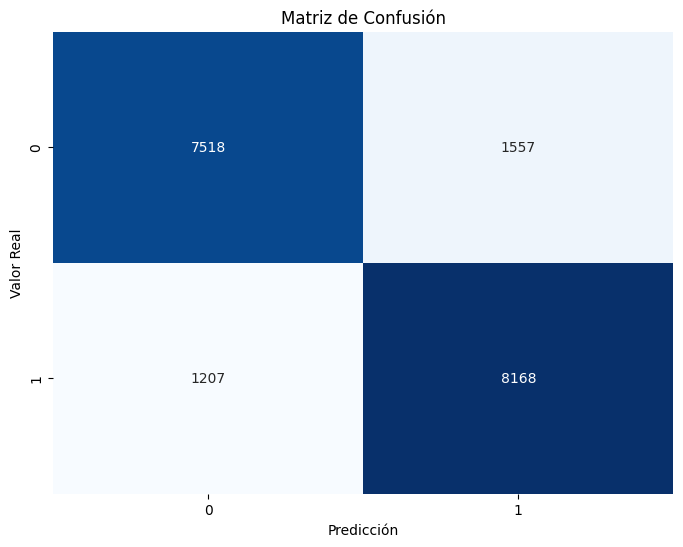

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

Árbol

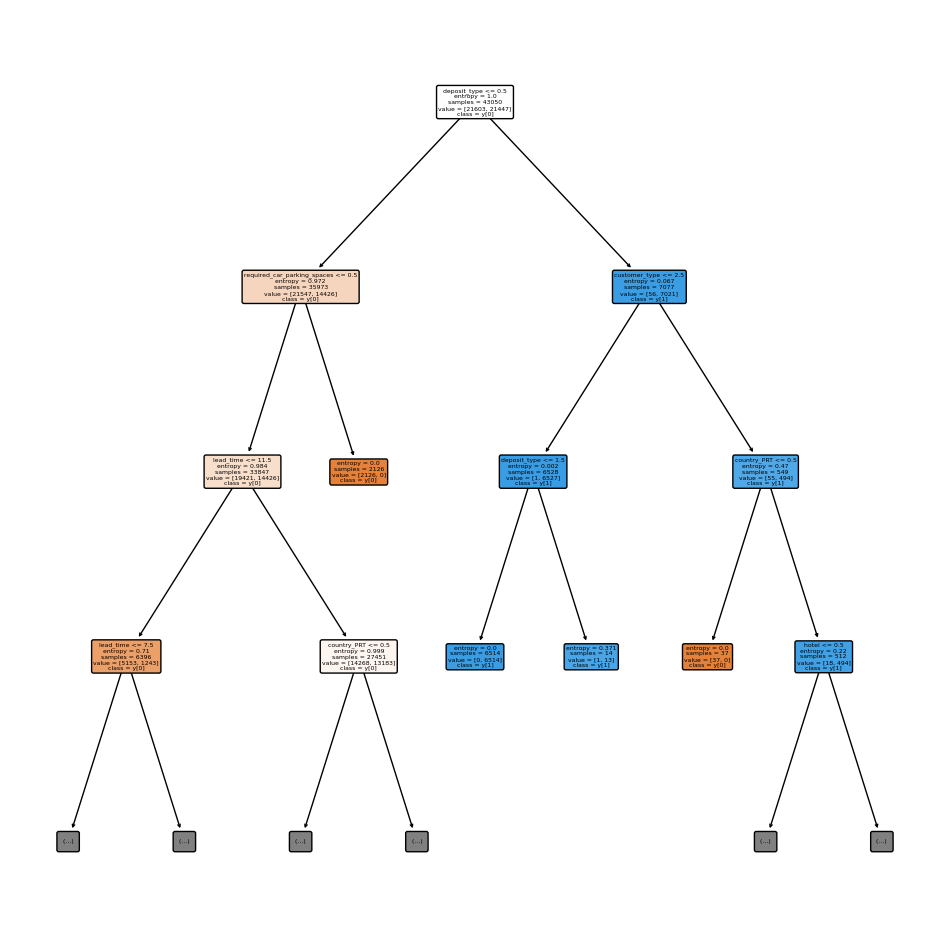

In [ ]:
from sklearn.tree import plot_tree
arbol = DecisionTreeClassifier().set_params(**randomcv.best_params_)
arbol.fit(x_train, y_train)

# Configura el tamaño y crea el gráfico del árbol
plt.figure(figsize=(12, 12))
tree_plot = plot_tree(
    arbol,
    max_depth=3,  # Ajusta la profundidad máxima según tu preferencia
    feature_names=x_train.columns.to_list(),
    filled=True,
    rounded=True,
    class_names=True
)

# Muestra el gráfico del árbol
plt.show()


### **Modelo 2**

En este modelo vamos a usar el criterio 'gini' a diferencia del modelo anterior, y a partir de los resultados obtenidos variar los parametros. Como en el modelo 1 usaremos el metodo Randomized Search Cross Validation.

A si mismo, tambien vamos a variar los parametros:


*   max_depth: criterio de parada (ej: máxima profundidad, osea, niveles/preguntas)
*   min_samples_leaf: cantidad minima de muestras para considerar un nodo como una hoja.
*   ccp_alpha: estrategia de poda
*   min_samples_split: cantidad de muestras que tiene que tener un nodo.

#### **Entrenamiento N1**

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini'],
               'max_depth':list(range(10, 30)),
               }


#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'max_depth': 17, 'criterion': 'gini'}
0.8476403429796063


In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.84473924, 0.8439358 , 0.84321844, 0.84764034, 0.84290577,
       0.83806315, 0.83979421, 0.84114484, 0.84607557, 0.84601248])

In [ ]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=17)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8475338753387534
Recall: 0.8698666666666667
Precision: 0.8365818629462454
f1 score: 0.8528996496365633


#### **Entrenamiento N2**

Tomamos el valor de max_depth = 19 y variamos el próximo parametro en el rango 1-10

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini'],
               'max_depth':[19],
               'min_samples_leaf':list(range(1, 10)),
               }

#Cantidad de splits para el Cross Validation
folds=10 #10, 15

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_leaf': 1, 'max_depth': 19, 'criterion': 'gini'}
0.8457989591797286


In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.84579896, 0.84276069, 0.84225251, 0.84147766, 0.84178806,
       0.84149917, 0.84086809, 0.84110699, 0.84110505])

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=19)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8479674796747968
Recall: 0.8666666666666667
Precision: 0.8393595041322314
f1 score: 0.8527945421149304


#### **Entrenamiento N3**

A partir del analisis anterior tomamos min_samples_leaf = 3 y procedemos a variar 'ccp_alpha'

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini'],
               'max_depth':[19],
               'min_samples_leaf':[3],
               'ccp_alpha': np.linspace(0.0001, 0.0002, 10)
               }

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

In [ ]:
randomcv.cv_results_['mean_test_score']

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

#### **Entrenamiento N4**

Por último tomamos ccp_alpha = 0.0001 y procedemos a variar el ultimo parametro 'min_samples_split'

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini'],
               'max_depth':[19],
               'min_samples_leaf':[2],
               'ccp_alpha': [0.0001],
               'min_samples_split': list(range(1, 10))
               }

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

In [ ]:
randomcv.cv_results_['mean_test_score']

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

### **Modelo 3**

Este modelo trata de buscar la mejor combinacion de hiperparametros con el metodo **Random Search Cross Validation**.

La cantidad de folds que usaremos sera de 5.

En este caso, entrenaremos al modelo en funcion del criterio 'gini', y otros parametros que no utilizamos anteriormente.

* max_depth: criterio de parada (ej: máxima profundidad, osea, niveles/preguntas)
* max_leaf_nodes: controla el número máximo de nodos hoja permitidos en el árbol.
* min_impurity_decrease: controla la cantidad mínima de disminución requerida en la impureza para realizar una división en un nodo del árbol de decisión.

#### **Entrenamiento N1**

Este entrenamiento se centrara en buscar el mejor hiperparametro **max_depth**.

Empezaremos cambiendo el criterio usado anteriormente, osea, a 'gini'.

Empezamos buscando un max_depth en el rango de 10-50, en donde los valores que tomaba mayormente era entre 10-30.

A medida que fuimos achicando el rango, encontramos una tendencia de la variable, que toma el valor 17.

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
param_grid = {
    'criterion': ['gini'],
    'max_depth': list(range(10, 20)),
}

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = param_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparametros que optimizan F1 score
randomcv.fit(x_train,y_train);

Observemos los parametros y el score que nos dio.

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

Los scores obtenidos en las distintas combinaciones.

In [ ]:
randomcv.cv_results_['mean_test_score']

Entrenamos.

In [ ]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

Predecimos.

In [ ]:
y_pred = arbol.predict(x_test)

Metricas.

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

#### **Entrenamiento N2**

Seguimos entrenando el modelo, esta vez buscando el mejor hiperparametro de **max_leaf_nodes**.

Los demas parametros lo sacamos del entrenamiento anterior.

Para este entrenamiento, decidimos buscar primero por los rango 500-1500, dando saltos de 100 (600, 700, 800...), en donde el valor mas frecuenta era entre el rango 950-1000.

Decidimos achicar el rango para dar mejor el valor preciso, que fue 984.

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
param_grid = {
    'criterion': ['gini'],
    'max_depth': [17],
    'max_leaf_nodes' : list(range(980, 990))
}

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = param_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparametros que optimizan F1 score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

In [ ]:
randomcv.cv_results_['mean_test_score']

In [ ]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

#### **Entrenamiento N3**

Seguimos entrenando el modelo, esta vez buscando el mejor hiperparametro de **min_impurity_decrease**.

Los demas parametros lo sacamos del entrenamiento anterior.

Para este entrenamiento, decidimos buscar primero por los rango 0.00000001-0.01, dando algunos saltos (0.01, 0.001, 0.0001, ...), en donde el valor mas frecuent era entre el rango 0.00001-0.000001.

Decidimos achicar el rango para dar mejor el valor preciso, que seria el de 0.00001-0.00002.

Pudimos observar que habia una tendencia en este rango, en donde valor daba 1.5555555555555555e-05.

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
param_grid = {
    'criterion': ['gini'],
    'max_depth': [17],
    'max_leaf_nodes' : [984],
    'min_impurity_decrease': np.linspace(0.00001, 0.00002,20)
    }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = param_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparametros que optimizan F1 score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

In [ ]:
randomcv.cv_results_['mean_test_score']

In [ ]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

In [ ]:
y_pred = arbol.predict(x_test)

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
model = arbol

## **Submission de prueba**

In [ ]:
x_submission = ds_test_copia
# Obtenemos las columnas de train y test
train_columns = x_train.columns
test_columns = x_submission.columns

# Buscamos columnas extra en el df test
extra_columns = set(test_columns) - set(train_columns)
print(extra_columns)

# Removemos las columnas extra
x_submission = x_submission.drop(columns=extra_columns)

Predecimos ahora si con el verdadero test.

In [ ]:
y_pred_final = model.predict(x_submission)

In [ ]:
df_submissing = pd.DataFrame({'id': ds_test['id'], 'is_canceled': y_pred_final.astype(int)})
df_submissing.head()

Exportamos.

In [ ]:
df_submissing.to_csv('./submission_14.csv', index=False)